In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [16]:
ndimage = PyCall.pyimport("scipy.ndimage");
rasterio = PyCall.pyimport("rasterio");
function _load_scalgo(depth_path, lake_path, geo_lut; scalgo_fill = -10, resample_fill=-100)
    
    ### Water depths
    depth_tiff = rasterio.open(depth_path);
    transform1 = depth_tiff.get_transform()
    scalgo_depth = depth_tiff.read(1);
    # Set new negative values    
    scalgo_depth[scalgo_depth .<0] .= scalgo_fill
    ## Resample 
    idx1 = reshape((geo_lut["latitude"].-transform1[4])./(transform1[6]),:);
    idx2 = reshape((geo_lut["longitude"].-transform1[1])./transform1[2],:);
    index = [idx1,idx2];
    flood_val  = ndimage.map_coordinates(scalgo_depth, index, order=1, mode="constant",cval=resample_fill);
    flood_val = reshape(flood_val,size(geo_lut["latitude"]));
    
    
    ### Lakes
    lakes_tiff = rasterio.open(lake_path);
    transform2 = lakes_tiff.get_transform()
    scalgo_lakes = lakes_tiff.read(1);
    # Set new negative values    
    scalgo_lakes[scalgo_lakes .<0] .= scalgo_fill
    # Resample 
    idx1 = reshape((geo_lut["latitude"].-transform2[4])./(transform2[6]),:);
    idx2 = reshape((geo_lut["longitude"].-transform2[1])./transform2[2],:);
    index = [idx1,idx2];
    lakes = ndimage.map_coordinates(scalgo_lakes, index, order=1, mode="constant",cval=resample_fill);
    lakes  = reshape(lakes ,size(geo_lut["latitude"]));
    
    
    return flood_val, lakes
end


function _count_mat(VV_flood,VH_flood,flood_val,lakes)
    
    scalgo_mask = flood_val .> -50;
    flood_mask = flood_val .> 0.15
    lake_mask = lakes .> 0.5;
    
    names = ["VV","VH","Scalgo no lake", "lake", "Scalgo raw"]
    data = [VV_flood, VH_flood, flood_mask .& .!(lake_mask), lake_mask , flood_mask];
    count_mat = [ sum((data[i] .& data[j])[scalgo_mask]) for i=1:length(data),j=1:length(data)]
    
    total_count = sum(scalgo_mask)
    
    freq_mat = zeros(size(count_mat))
    [freq_mat[j,:] .= count_mat[j,:]./ count_mat[j,j] for j=1:length(data)]
    
    return count_mat, freq_mat, total_count, names
end
    

_count_mat (generic function with 1 method)

# Vejle 

In [2]:
data_folder= "/home/data/simon/processed/test_areas/vejle_new"

flood_mask_folder = "/home/data/simon/result/HSBA_loss2/HSBA_vejle"

"/home/data/simon/result/HSBA_loss2/HSBA_vejle"

In [3]:
VV_flood = JLD.load(joinpath(flood_mask_folder,"VV_flood_mask.jld"),"data")[:,end:-1:1];
VH_flood = JLD.load(joinpath(flood_mask_folder,"VH_flood_mask.jld"),"data")[:,end:-1:1];
geo_lut = JLD.load(joinpath(data_folder ,"coordinates.jld"));

In [4]:
VV = [JLD.load(joinpath(data_folder,"flood/VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"flood/VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"flood/VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"flood/VH_pre_median.jld"),"data")];

###  Vejle 1

In [17]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle_1"

"/home/data/simon/result/scalgo/vejle_1"

In [18]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"vanddybde_vejle1.tif"), 
                                joinpath(scalgo_folder,"geo_dk_lakes_vejle1.tif"),
                                geo_lut);
    

In [19]:
count_mat_v1, freq_mat_v1,
total_count_v1, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [20]:
count_mat_v1

5×5 Array{Int64,2}:
 312   8   33    13    46
   8  85   57     0    57
  33  57  974     0   974
  13   0    0  1704  1645
  46  57  974  1645  2619

In [21]:
freq_mat_v1

5×5 Array{Float64,2}:
 1.0         0.025641   0.105769  0.0416667  0.147436
 0.0941176   1.0        0.670588  0.0        0.670588
 0.0338809   0.0585216  1.0       0.0        1.0     
 0.00762911  0.0        0.0       1.0        0.965376
 0.017564    0.021764   0.371898  0.628102   1.0     

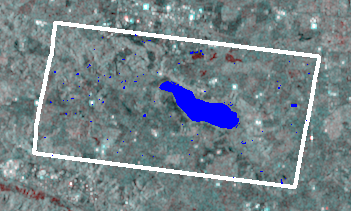

In [25]:
zoom_view = [140:350,1150:1500]
imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

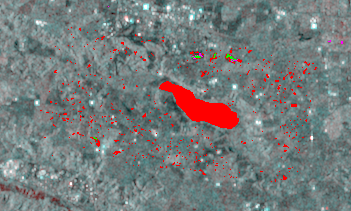

In [23]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VH_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VH_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VH_flood,(1,0,1) )[zoom_view...]


### Vejle 2

In [26]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle2"

"/home/data/simon/result/scalgo/vejle2"

In [27]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_vejle2.tif"),
                                geo_lut);
    

In [28]:
count_mat_v2, freq_mat_v2,
total_count_v2, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [29]:
count_mat_v2

5×5 Array{Int64,2}:
 672   19   190    3   192
  19  112    95    0    95
 190   95  1915    0  1915
   3    0     0  154   113
 192   95  1915  113  2028

In [30]:
freq_mat_v2

5×5 Array{Float64,2}:
 1.0        0.0282738  0.282738  0.00446429  0.285714
 0.169643   1.0        0.848214  0.0         0.848214
 0.0992167  0.0496084  1.0       0.0         1.0     
 0.0194805  0.0        0.0       1.0         0.733766
 0.0946746  0.0468442  0.94428   0.0557199   1.0     

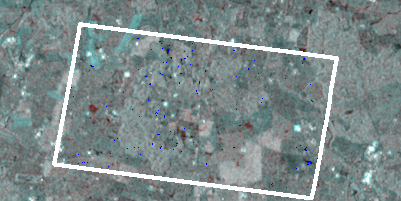

In [39]:
zoom_view = [600:800,800:1200]
imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

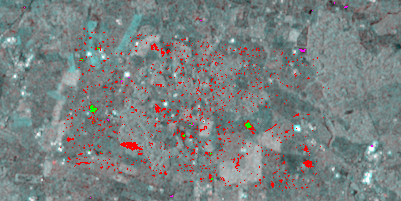

In [40]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VH_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VH_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VH_flood,(1,0,1) )[zoom_view...]


### Vejle 3

In [26]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle3"

"/home/data/simon/result/scalgo/vejle2"

In [27]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_vejle3.tif"),
                                geo_lut);
    

In [62]:
count_mat_v3, freq_mat_v3,
total_count_v3, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [63]:
count_mat_v3

5×5 Array{Int64,2}:
 914   20    1    60    1
  20  582    1    13    1
   1    1  141     0  141
  60   13    0  2603    0
   1    1  141     0  141

In [64]:
freq_mat_v3

5×5 Array{Float64,2}:
 1.0        0.0218818   0.00109409  0.0656455  0.00109409
 0.0343643  1.0         0.00171821  0.0223368  0.00171821
 0.0070922  0.0070922   1.0         0.0        1.0       
 0.0230503  0.00499424  0.0         1.0        0.0       
 0.0070922  0.0070922   1.0         0.0        1.0       

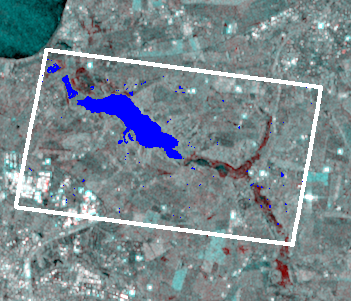

In [51]:
zoom_view = [500:800,300:650]
imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

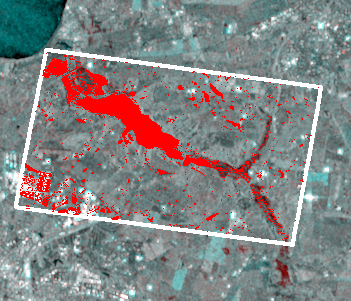

In [61]:
zoom_view = [500:800,300:650]
imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,flood_val .> 0 ,(1,0,0))[zoom_view...]

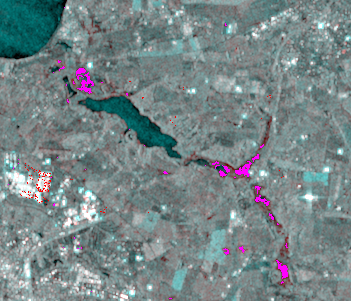

In [52]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VH_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VH_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VH_flood,(1,0,1) )[zoom_view...]


# Ribe

In [68]:
data_folder= "/home/data/simon/processed/test_areas/ribe_new"

flood_mask_folder = "/home/data/simon/result/HSBA_loss2/HSBA_ribe"

"/home/data/simon/result/HSBA_loss2/HSBA_ribe"

In [69]:
VV_flood = JLD.load(joinpath(flood_mask_folder,"VV_flood_mask.jld"),"data")[end:-1:1,:];
VH_flood = JLD.load(joinpath(flood_mask_folder,"VH_flood_mask.jld"),"data")[end:-1:1,:];
geo_lut = JLD.load(joinpath(data_folder ,"coordinates.jld"));

In [70]:
VV = [JLD.load(joinpath(data_folder,"flood/VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"flood/VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"flood/VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"flood/VH_pre_median.jld"),"data")];

### Ribe 1

In [128]:
scalgo_folder = "/home/data/simon/result/scalgo/ribe1"

"/home/data/simon/result/scalgo/ribe1"

In [129]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_ribe1.tif"),
                                geo_lut);
    

In [130]:
count_mat_r1, freq_mat_r1,
total_count_r1, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [131]:
count_mat_r1

5×5 Array{Int64,2}:
 8151  6654   281   5   283
 6654  7029   252   8   259
  281   252  1255   0  1255
    5     8     0  56    11
  283   259  1255  11  1266

In [132]:
freq_mat_r1

5×5 Array{Float64,2}:
 1.0        0.816342  0.0344743  0.000613422  0.0347197
 0.94665    1.0       0.0358515  0.00113814   0.0368473
 0.223904   0.200797  1.0        0.0          1.0      
 0.0892857  0.142857  0.0        1.0          0.196429 
 0.223539   0.204581  0.991311   0.00868878   1.0      

In [133]:
zoom_view = [650:840,200:500];

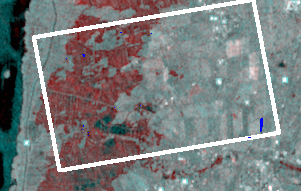

In [134]:

imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

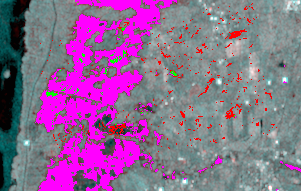

In [135]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VH_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VH_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VH_flood,(1,0,1) )[zoom_view...]


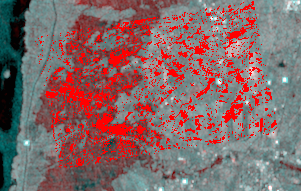

In [136]:
add_mask(imgVV,flood_val .> 0 ,(1,0,0))[zoom_view...]

### Ribe 2

In [137]:
scalgo_folder = "/home/data/simon/result/scalgo/ribe2"

"/home/data/simon/result/scalgo/ribe2"

In [138]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_ribe2.tif"),
                                geo_lut);
    

In [139]:
count_mat_r2, freq_mat_r2,
total_count_r2, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [140]:
count_mat_r2

5×5 Array{Int64,2}:
 1932  1087   306   2   308
 1087  1134   133   3   135
  306   133  1049   0  1049
    2     3     0  49    37
  308   135  1049  37  1086

In [141]:
freq_mat_r2

5×5 Array{Float64,2}:
 1.0        0.562629   0.158385  0.0010352  0.15942 
 0.958554   1.0        0.117284  0.0026455  0.119048
 0.291706   0.126787   1.0       0.0        1.0     
 0.0408163  0.0612245  0.0       1.0        0.755102
 0.28361    0.124309   0.96593   0.03407    1.0     

In [142]:
zoom_view = [1000:1240,150:400];

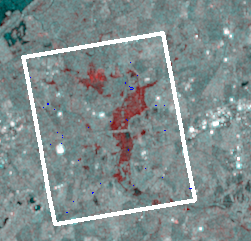

In [143]:

imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

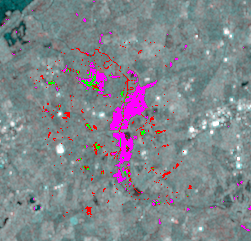

In [144]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VV_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VV_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VV_flood,(1,0,1) )[zoom_view...]


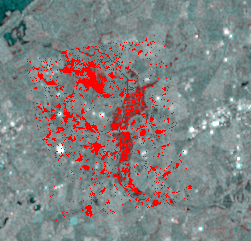

In [145]:
add_mask(imgVV,flood_val .> 0 ,(1,0,0))[zoom_view...]

### Ribe 3

In [146]:
scalgo_folder = "/home/data/simon/result/scalgo/ribe3"

"/home/data/simon/result/scalgo/ribe3"

In [147]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_ribe3.tif"),
                                geo_lut);
    

In [148]:
count_mat_r3, freq_mat_r3,
total_count_r3, names =_count_mat(VV_flood,VH_flood,
                                flood_val,lakes)
names

5-element Array{String,1}:
 "VV"            
 "VH"            
 "Scalgo no lake"
 "lake"          
 "Scalgo raw"    

In [149]:
count_mat_r3

5×5 Array{Int64,2}:
 4277  3020   161    7   163
 3020  3904   181    3   182
  161   181  2021    0  2021
    7     3     0  111    52
  163   182  2021   52  2073

In [150]:
freq_mat_r3

5×5 Array{Float64,2}:
 1.0        0.706102   0.0376432  0.00163666   0.0381108
 0.773566   1.0        0.0463627  0.000768443  0.0466189
 0.0796635  0.0895596  1.0        0.0          1.0      
 0.0630631  0.027027   0.0        1.0          0.468468 
 0.07863    0.0877955  0.974916   0.0250844    1.0      

In [151]:
zoom_view = [350:650,400:750];

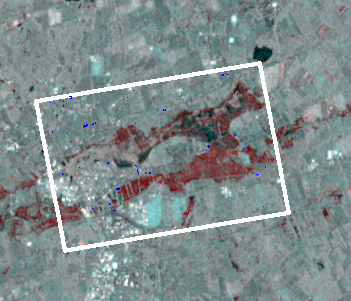

In [152]:

imgVV = pretty_img(VV,min_vv,max_vv)
subset_edges = get_edges(flood_val .> -50,1);
test_1 = add_mask(imgVV,subset_edges,(1,1,1))
add_mask(test_1,(lakes .> 0) ,(0,0,1))[zoom_view...]

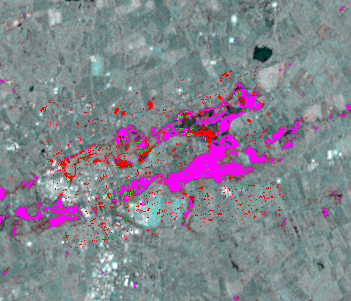

In [153]:
test = add_mask(imgVV,(flood_val .> 0.15) .& VH_flood,(0,1,0))
test = add_mask(test,(flood_val .> 0.15) .& (VH_flood.==false),(1,0,0) )
add_mask(test,(flood_val .< 0.15) .& VH_flood,(1,0,1) )[zoom_view...]


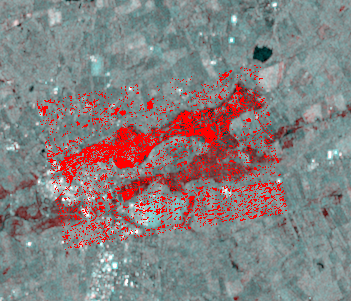

In [154]:
add_mask(imgVV,flood_val .> 0 ,(1,0,0))[zoom_view...]